# Import Library

In [1]:
pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 606.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: idna
    Found existing installation: idna 3.3
    Uninstalling idna-3.3:
      Successfully uninstalled idna-3.3
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
  Attempting uninstall: pandas
    Found existing installation: pa

In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

# Reading the Dataset

1. 5640 images, 47 categories, 120 images for each category.
1. Image size range between 300*300 and 640*640
1. images contain at least 90% of the surface representing the category attribute

In [3]:
#이미지 사이즈 조정후(480*480 으로 통일) 텐서로 변환
transf = transforms.Compose([transforms.Resize((480,480)),transforms.ToTensor()])
dtd_train = torchvision.datasets.DTD(
    root="../data", split='train', transform=transf, download=True)
dtd_test = torchvision.datasets.DTD(
    root="../data", split='test', transform=transf, download=True)

  0%|          | 0/625239812 [00:00<?, ?it/s]

Extracting ../data/dtd/dtd-r1.0.1.tar.gz to ../data/dtd


In [4]:
len(dtd_train),len(dtd_test)

(1880, 1880)

In [5]:
dtd_train[0][0].shape

torch.Size([3, 480, 480])

In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
# PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

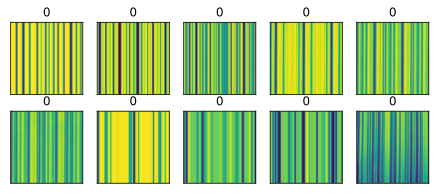

In [7]:
X, y = next(iter(data.DataLoader(dtd_train, batch_size=10)))
# #(batch * channel) * height * width
show_images(X.reshape(30,480,480), 2, 5, titles=y.tolist());

# Reading a Minibatch

In [8]:
batch_size = 256
def get_dataloader_workers():  #@save
    """Use 4 processes to read the data."""
    return 4
train_iter = data.DataLoader(dtd_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'25.77 sec'

# Putting All things together

In [10]:
def load_data_dtd(batch_size, resize=None):  #@save
    """Download the dtd dataset and then load it into memory."""
    trans= [transforms.Resize((480,480)),transforms.ToTensor()] #size 480*480으로 통일
    if resize:
        del trans[0]
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    dtd_train = torchvision.datasets.DTD(
    root="../data", split='train', transform=trans, download=True)
    dtd_test = torchvision.datasets.DTD(
    root="../data", split='test', transform=trans, download=True)
    return (data.DataLoader(dtd_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(dtd_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [11]:
train_iter, test_iter = load_data_dtd(20,resize=(500,500))
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([20, 3, 500, 500]) torch.float32 torch.Size([20]) torch.int64


# Implementation of Softmax Regression from Scratch

In [12]:
import torch
from IPython import display
from d2l import torch as d2l

In [13]:
batch_size = 120
train_iter, test_iter = load_data_dtd(batch_size)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([120, 3, 480, 480]) torch.float32 torch.Size([120]) torch.int64


## Initializing Model Parameters

In [14]:
num_inputs = 691200 #flatten image = 3*480*480
num_outputs = 47

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## Defining the softmax operation

In [15]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)
#axis=0 >> column 방향
#axis=1 >> row방향

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [16]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True) #행방향 합
    return X_exp / partition  # The broadcasting mechanism is applied here

In [17]:
X = torch.normal(0, 1, (2, 5))  #mean, std, tensor size
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2077, 0.3743, 0.1479, 0.1073, 0.1629],
         [0.0903, 0.0555, 0.6097, 0.1152, 0.1293]]),
 tensor([1.0000, 1.0000]))

## Defining the Model

In [18]:
 def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [19]:
for X,y in train_iter:  #net X값이 잘 나오는 지 확인하기 
    print(net(X))
    break

tensor([[7.4195e-08, 3.5313e-04, 6.7039e-05,  ..., 7.6937e-08, 1.6552e-03,
         1.0430e-01],
        [6.1297e-08, 5.2673e-03, 6.6396e-03,  ..., 1.3712e-05, 1.3541e-02,
         3.0537e-02],
        [5.7366e-10, 1.2265e-04, 9.7921e-05,  ..., 2.0314e-09, 4.2868e-04,
         5.4328e-03],
        ...,
        [9.0860e-08, 1.6935e-05, 1.2626e-02,  ..., 3.0471e-08, 2.2513e-04,
         8.6318e-01],
        [2.0162e-10, 1.2394e-07, 9.3134e-07,  ..., 4.3008e-10, 9.0202e-06,
         2.3524e-03],
        [2.7628e-08, 1.4044e-05, 2.4590e-03,  ..., 1.0536e-07, 4.7700e-03,
         5.4848e-02]], grad_fn=<DivBackward0>)


## Defining the Loss Function

In [20]:
y = torch.tensor([0, 2]) #2개의 example에 대해 각각 1번째 클래스, 3번째 클래스가 정확한 예측
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y] #[0,1]은 y_hat의 index의미 >> y_hat에서 각각 1번쨰 클래스, 3번쨰 클래스 값 출력

tensor([0.1000, 0.5000])

In [21]:
import sys
import numpy as np

In [22]:
def cross_entropy(y_hat, y):
    result = -torch.log(y_hat[range(len(y_hat)), y])
    result_list = result.tolist()
    for n,i in enumerate(result_list):
        if i == np.inf: #-log값이 inf가 나오는 경우가 있어 오류를 방지하기 위해 sys.maxsize로 대체 
            result_list[n] = sys.maxsize
    return torch.tensor(result_list)

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [23]:
def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [24]:
accuracy(y_hat, y) / len(y)

0.5

In [25]:
def evaluate_accuracy(net, data_iter):  
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) #numel: 입력 텐서의 총 요소 수 반환
    return metric[0] / metric[1]

In [26]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [27]:
evaluate_accuracy(net, test_iter) #47class random guessing

0.018617021276595744

## Training

In [28]:
def train_epoch_ch3(net, train_iter, loss, updater): 
    if isinstance(net, torch.nn.Module):
        net.train() #train mode
        
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3) #3개 값 저장
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat,y)
        l = l.clone().detach().requires_grad_(True) #requirs_grad = True: autograd에 모든 연산 추적해야 한다고 알려줌
        
        if isinstance(updater, torch.optim.Optimizer): #torch 내장 optimizer 사용
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad() #backpropagation 하기 전 gradient 초기화
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater() 
        
        #loss, accuracy, element 개수 저장 
        torch.autograd.set_detect_anomaly(True) #Nan loss가 발생했을 때 학습 중단
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [29]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
             if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [30]:
from tqdm import tqdm #for문 시간 계산 가능

In [31]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    animator_acc = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0,0.2],
                        legend=['train acc', 'test acc'])
    animator_loss = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0,20],
                        legend=['train loss'])
    for epoch in tqdm(range(num_epochs)):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        train_loss, train_acc = train_metrics
        print(train_loss, train_acc)
        
        test_acc = evaluate_accuracy(net, test_iter)
        animator_acc.add(epoch + 1, (train_acc,) + (test_acc,)) #tuple로 들어감
        animator_loss.add(epoch+1,train_loss)

    
# 모델의 성능이 좋지 않아 assert 부문을 주석처리하였습니다.
#     assert train_loss < 10, train_loss
#     assert train_acc <= 1 and train_acc > 0.7, train_acc
#     assert test_acc <= 1 and test_acc > 0.7, test_acc

In [32]:
lr = 0.001
def updater(): #d2l.SGD는 오류가 계속 나서 torch를 이용했습니다
    return torch.optim.SGD([W,b], lr)

100%|██████████| 10/10 [08:38<00:00, 51.84s/it]


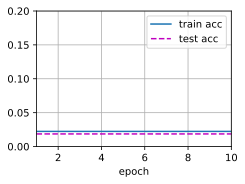

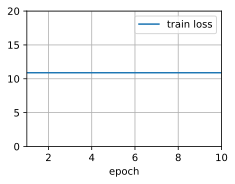

In [33]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## Prediction

In [34]:
def predict_ch3(net, test_iter, n=6):  #@save
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = y.tolist()
    preds = net(X).argmax(axis=1).tolist()
    titles = [str(true) +'\n' + str(pred) for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((3*n,480,480)), 1, n, titles=titles[0:n])

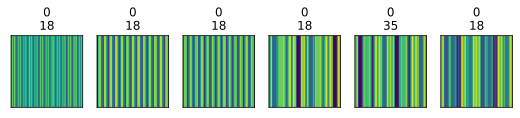

In [35]:
predict_ch3(net, test_iter)

# With Torch function

In [36]:
import torch
from torch import nn
from d2l import torch as d2l

In [37]:
batch_size = 120
train_iter, test_iter = load_data_dtd(batch_size)

## Initializing model parameters

In [38]:
# PyTorch does not implicitly reshape the inputs. 
# flatten layer to reshape the inputs before the linear layer in our network
net = nn.Sequential(nn.Flatten(), nn.Linear(691200, 47))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01) #zero mean, std = 0.01
net.apply(init_weights);

In [39]:
#Softmax를 이용한 loss function
loss = nn.CrossEntropyLoss(reduction='none')

In [40]:
#Optimization Algorithm
trainer = torch.optim.SGD(net.parameters(), lr=0.001)

100%|██████████| 10/10 [08:34<00:00, 51.42s/it]


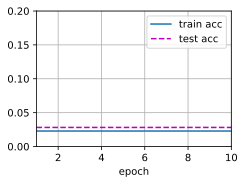

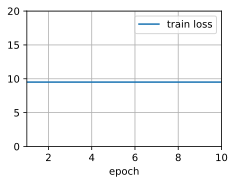

In [41]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)